In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
from pathlib import Path

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
main_dir = "drive/MyDrive/Capstone Project Bukit Vista Repo/Dataset/"

In [5]:
clust_df = pd.read_csv(main_dir + "final_data_new_regency.csv")

In [6]:
clust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   unit_id                   373 non-null    object 
 1   unit_name                 373 non-null    object 
 2   property_id               373 non-null    object 
 3   total_guest_capacity      373 non-null    float64
 4   bedroom                   373 non-null    float64
 5   bathroom                  373 non-null    float64
 6   beds                      373 non-null    float64
 7   avg_price_per_day         373 non-null    float64
 8   property_name             373 non-null    object 
 9   property_type             373 non-null    float64
 10  google_map_link           373 non-null    object 
 11  area_distance_to_airport  373 non-null    float64
 12  area_name                 373 non-null    object 
 13  type_desc                 373 non-null    object 
 14  lat       

# Model K-Means

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = ['total_guest_capacity', 'avg_price_per_day', 'lat','lng','area_distance_to_airport']
cat_cols = ['property_type', 'area_regency_city']

scaler = MinMaxScaler()
encoder = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', encoder, cat_cols)
    ])

cluster = KMeans(n_clusters=10, init='random', n_init=100, max_iter=500, tol=1e-04, random_state=0)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('cluster', cluster)])

pipeline.fit(clust_df)
cluster_labels = pipeline.named_steps['cluster'].labels_

clust_df['cluster_label'] = cluster_labels

print(clust_df[['unit_id', 'cluster_label']])

    unit_id  cluster_label
0    UN0165              5
1    UN1536              5
2    UN1537              5
3    UN1538              5
4    UN1539              5
..      ...            ...
368  UN3099              6
369  UN3100              6
370  UN3101              6
371  UN3102              6
372  UN3103              6

[373 rows x 2 columns]


In [8]:
from sklearn.metrics import silhouette_score

X_transformed = pipeline.transform(clust_df)

silhouette = silhouette_score(X_transformed, cluster_labels)

print(f'Silhouette score: {silhouette}')

Silhouette score: 0.88056336036968


In [9]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X_transformed, cluster_labels)

print(f'Davies-Bouldin index: {db_score}')

Davies-Bouldin index: 0.40120900143894145


In [10]:
cluster_counts = clust_df['cluster_label'].value_counts()

for i in range(cluster_counts.shape[0]):
    print(f"Cluster {i}: {cluster_counts[i]}")

Cluster 0: 19
Cluster 1: 10
Cluster 2: 46
Cluster 3: 20
Cluster 4: 33
Cluster 5: 113
Cluster 6: 52
Cluster 7: 8
Cluster 8: 58
Cluster 9: 14


## Visualisasi 2D & 3D

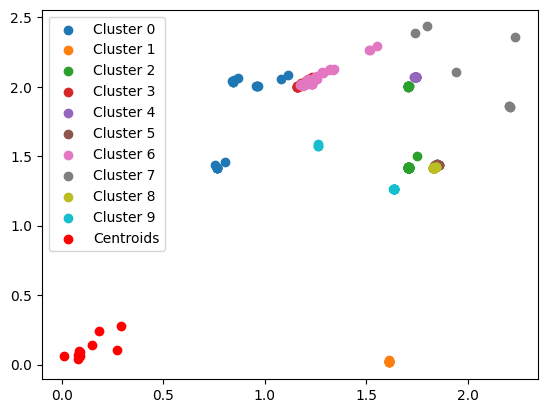

In [11]:
import matplotlib.pyplot as plt

X_transformed = pipeline.transform(clust_df)

for i in range(cluster_counts.shape[0]):
    plt.scatter(X_transformed[cluster_labels == i, 0], X_transformed[cluster_labels == i, 1], label=f'Cluster {i}')

centroids = pipeline.named_steps['cluster'].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', label='Centroids')

plt.legend()

plt.show()

In [12]:
import folium
from folium.plugins import MarkerCluster

map_center = [clust_df['lat'].mean(), clust_df['lng'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Warna untuk setiap cluster (10 warna berbeda)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

# Buat MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# Menambahkan marker ke cluster
for idx, row in clust_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=f"Cluster {row['cluster_label']} {row['unit_id']} {row['unit_name']}",
        icon=folium.Icon(color=colors[row['cluster_label'] % len(colors)])
    ).add_to(marker_cluster)

In [33]:
display(m)

In [34]:
m.save('clustering_map.html')

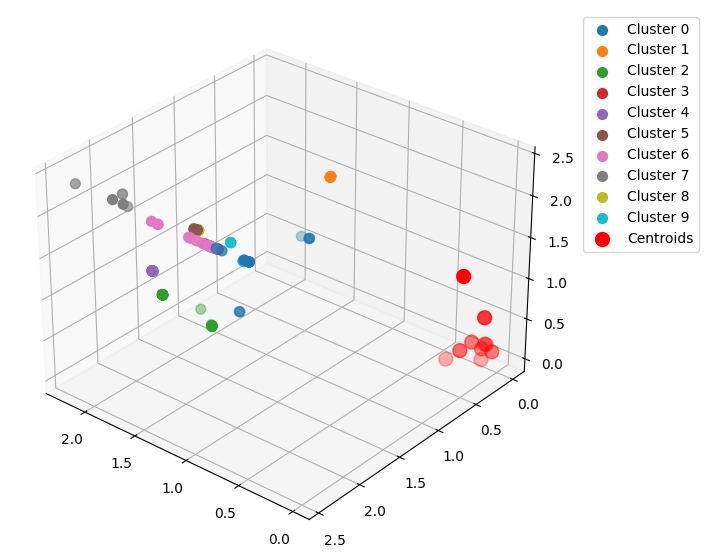

In [35]:
from mpl_toolkits.mplot3d import Axes3D

# Asumsi X_transformed adalah array dengan setidaknya 3 kolom
X_transformed = pipeline.transform(clust_df)

# Membuat figure dan axes 3D dengan ukuran gambar yang lebih besar
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Visualisasi setiap cluster dalam 3D dengan ukuran marker yang lebih besar
for i in range(cluster_counts.shape[0]):
    ax.scatter(X_transformed[cluster_labels == i, 0], X_transformed[cluster_labels == i, 1], X_transformed[cluster_labels == i, 2], s=50, label=f'Cluster {i}')

# Visualisasi centroid dalam 3D dengan ukuran marker yang lebih besar
centroids = pipeline.named_steps['cluster'].cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=100, c='red', label='Centroids')

# Mengubah sudut pandang untuk memperbaiki tampilan
ax.view_init(elev=30, azim=130)

# Menambahkan legenda di luar kotak plot dengan penyesuaian posisi
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Menampilkan plot
plt.show()

In [37]:
import plotly.graph_objs as go
import plotly.express as px
import numpy as np

# Asumsi X_transformed adalah array dengan setidaknya 3 kolom
X_transformed = pipeline.transform(clust_df)

# Membuat plotly figure
fig = go.Figure()

# Visualisasi setiap cluster dalam 3D
for i in range(cluster_counts.shape[0]):
    fig.add_trace(go.Scatter3d(
        x=X_transformed[cluster_labels == i, 0],
        y=X_transformed[cluster_labels == i, 1],
        z=X_transformed[cluster_labels == i, 2],
        mode='markers',
        marker=dict(size=5),
        name=f'Cluster {i}'
    ))

# Menambahkan layout
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    legend=dict(x=1, y=0.5)
)

# Menampilkan plot
fig.show()


# Show each cluster

In [ ]:
pd.set_option('display.max_rows', None)

# Loop over the cluster labels
for i in range(cluster_counts.shape[0]):  # Change this to the number of clusters you have
    cluster_data = clust_df[clust_df['cluster_label'] == i]
    print("---------------------------------------------------------------------------------------------------------------------------++")
    print(f"Cluster {i} data:")
    print(cluster_data)
    print("\n")

# Perform the similarity to find the several closest unit

In [14]:
from sklearn.metrics.pairwise import euclidean_distances

def find_similar_units(unit_id, clust_df, num_cols, cat_cols, priority_factor=2):
    # Retrieve data with the given unit_id
    input_data = clust_df[clust_df['unit_id'] == unit_id]
    if input_data.empty:
        print(f"No data found for unit_id {unit_id}.")
        return None

    # Fit the preprocessor on the entire dataset
    preprocessor.fit(clust_df[num_cols + cat_cols])

    # Filter the DataFrame to only include rows from the same cluster as the input
    input_cluster = input_data['cluster_label'].values[0]
    filtered_clust_df = clust_df[clust_df['cluster_label'] == input_cluster]

    # If there are no units in the same cluster, fallback to the entire dataset
    if filtered_clust_df.empty:
        filtered_clust_df = clust_df.copy()

    # Reset the index of filtered_clust_df
    filtered_clust_df = filtered_clust_df.reset_index(drop=True)

    # Apply the preprocessor to the filtered dataset
    X_transformed = preprocessor.transform(filtered_clust_df[num_cols + cat_cols])

    # Retrieve the transformed feature names
    num_features = num_cols
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
    all_features = np.concatenate([num_features, cat_features])

    # Identify the index of the 'avg_price_per_day' column
    price_col_index = np.where(all_features == 'avg_price_per_day')[0][0]

    # Identify the indices of the 'area_regency_city' columns (one-hot encoded)
    area_cols_indices = [i for i, col in enumerate(all_features) if col.startswith('area_regency_city')]

    # Apply the priority factor to the priority columns
    X_transformed[:, price_col_index] *= priority_factor
    X_transformed[:, area_cols_indices] *= priority_factor

    # Extract the features from the input data
    input_features = input_data[num_cols + cat_cols]

    # Apply the preprocessor to the input features
    input_transformed = preprocessor.transform(input_features)

    # Apply the priority factor to the priority columns in the input data
    input_transformed[:, price_col_index] *= priority_factor
    input_transformed[:, area_cols_indices] *= priority_factor

    # Calculate the distance between the input data and each data in the same cluster using Euclidean distance
    distances = euclidean_distances(input_transformed, X_transformed)

    # Filter data by the same area_regency_city
    input_area_regency_city = input_data['area_regency_city'].values[0]
    same_area_indices = filtered_clust_df[filtered_clust_df['area_regency_city'] == input_area_regency_city].index

    # Define input_property_id before the if statement
    input_property_id = input_data['property_id'].values[0]

    # If there are units in the same area_regency_city, prioritize them
    if len(same_area_indices) > 1:
        # Filter distances to only consider units in the same area_regency_city
        same_area_distances = {index: distances[0, index] for index in same_area_indices if filtered_clust_df.iloc[index]['property_id'] != input_property_id}
        # Sort distances within the same area_regency_city
        sorted_indices = sorted(same_area_distances, key=same_area_distances.get)[:3]
    else:
        # If no units are in the same area_regency_city, fallback to the all the dataset
        sorted_distances = np.argsort(distances[0])
        # Filter out data that has the same property_id as the input
        filtered_indices = [index for index in sorted_distances if filtered_clust_df.iloc[index]['property_id'] != input_property_id]
        # Select the 3 nearest qualifying data points
        sorted_indices = filtered_indices[:3]

    # Return the 3 nearest data points
    closest_data = filtered_clust_df.iloc[sorted_indices]

    # If closest_data is still empty, calculate distances for the entire dataset and return the 3 nearest units
    if closest_data.empty:
        X_transformed_all = preprocessor.transform(clust_df[num_cols + cat_cols])
        distances_all = euclidean_distances(input_transformed, X_transformed_all)
        sorted_distances_all = np.argsort(distances_all[0])
        filtered_indices_all = [index for index in sorted_distances_all if clust_df.iloc[index]['property_id'] != input_property_id]
        sorted_indices_all = filtered_indices_all[:3]
        closest_data = clust_df.iloc[sorted_indices_all]

    return closest_data

In [ ]:
print(find_similar_units('UN1539', clust_df, num_cols, cat_cols))

In [16]:
clust_df[clust_df['unit_id'] == 'UN1539']

,unit_id,unit_name,property_id,total_guest_capacity,bedroom,bathroom,beds,avg_price_per_day,property_name,property_type,google_map_link,area_distance_to_airport,area_name,type_desc,lat,lng,area_regency_city,cluster_label
4,UN1539,Apartment - 1 Lantai 1,PR0120,2.0,1.0,1.0,1.0,1.067696e+06,Bingin Ombak,4.0,https://goo.gl/maps/kpNF6FeFzTxrPi2B8,0.75,Bingin,Guesthouse,-8.805646,115.113378,10,5


In [ ]:
print(find_similar_units('UN2320', clust_df, num_cols, cat_cols))

In [ ]:
clust_df[clust_df['unit_id'] == 'UN2320']

In [ ]:
print(find_similar_units('UN3057', clust_df, num_cols, cat_cols))

In [ ]:
clust_df[clust_df['unit_id'] == 'UN3057']

In [ ]:
print(find_similar_units('UN2127', clust_df, num_cols, cat_cols))

In [ ]:
clust_df[clust_df['unit_id'] == 'UN2127']

In [ ]:
print(find_similar_units('UN2785', clust_df, num_cols, cat_cols))

In [ ]:
clust_df[clust_df['unit_id'] == 'UN2785']

In [ ]:
print(find_similar_units('UN2992', clust_df, num_cols, cat_cols))

In [ ]:
clust_df[clust_df['unit_id'] == 'UN2992']

In [ ]:
print(find_similar_units('UN3025', clust_df, num_cols, cat_cols))

In [ ]:
clust_df[clust_df['unit_id'] == 'UN3025']

In [ ]:
print(find_similar_units('UN3008', clust_df, num_cols, cat_cols))

In [ ]:
clust_df[clust_df['unit_id'] == 'UN3008']

In [ ]:
print(find_similar_units('UN2797', clust_df, num_cols, cat_cols))

In [ ]:
clust_df[clust_df['unit_id'] == 'UN2797']